<center><p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<center><h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# <center>Домашнее задание. NST Pytorch

Выполнил: Дмитрий Шерешевский, ID 36196483
(Dmitry Shereshevskiy)

## Комментарий
- Задание выполнено на базе ноутбука с семинара
- Основные изменения - в классе StyleLoss, плюс некоторые изменения по коду
- Добавлены примеры (см. в конце)

Нейронный перенос стиля с Pytorch
============================
**Aвтор**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке объясняется и показывается, как работает алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Леона А. Гатиса, Александра С. Эккера и Маттиаса Бетге.


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:



**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.


Это все что нам понадобится:

### Введение
Архитектуры подробно изложены в https://arxiv.org/pdf/1703.10593.pdf (1) и https://arxiv.org/pdf/1603.08155.pdf (2). Реализованная здесь архитектура полностью соответствует описаниям в статьях.    
Для дискриминатора использована упомянутая в статьях архтектура Markovian discriminator (PatchGAN). Его идею можно посмотреть, в частности, [здесь](https://www.researchgate.net/figure/The-patchGAN-discriminator-input-of-discriminator-is-either-the-pair-of-sketch-yellow_fig2_325291567).    
Было изучено несколько реализаций CycleGAN, в том числе и на соответствие принципам, изложенным в исходниках (1) и (2). Некоторые идеи для реализации отдельных частей архитектур, которые показались удачными и соответствующими исходным статьям, взяты отсюда https://github.com/aitorzip/PyTorch-CycleGAN, дабы не изобретать велосипед. 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir("gdrive/MyDrive/Colab Notebooks/DLSchool_mipt_1sem/style_transfer/")

In [ ]:
# !pip3 install torch torchvision
# !pip3 install pillow==4.1.1

In [ ]:
# %matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
!ls images/

dancing.jpg  lisa.jpg  picasso.jpg


**Загрузка изображений**

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [ ]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/picasso.jpg")# as well as here
content_img = image_loader("images/lisa.jpg")#измените путь на тот который у вас.

#### стили

In [ ]:
style_img1 = image_loader("images/picasso.jpg")
style_img2 = image_loader("images/dancing.jpg")

style_imgs = [style_img1, style_img2]

Выведем то, что было загружено

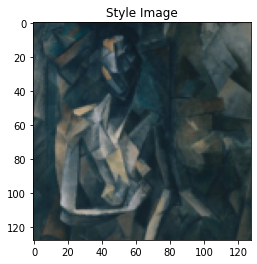

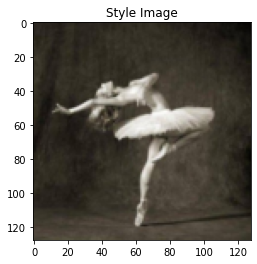

In [ ]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_imgs[0], title='Style Image')

plt.figure()
imshow(style_imgs[1], title='Style Image')

### маска

In [ ]:
shape = style_img.shape
mask1 = torch.cat([torch.ones((shape[0], shape[1], shape[2]//2, shape[3])), torch.zeros((shape[0], shape[1], shape[2]//2, shape[3]))], dim=2)
mask2 = torch.abs(mask1 - 1)

masks = [mask1, mask2]

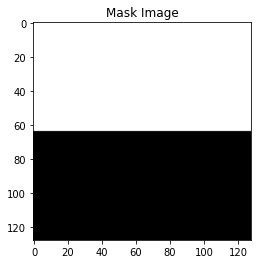

In [ ]:
imshow(mask1, title='Mask Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [ ]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target)#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

In [ ]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

Матрица грама готова, теперь нужно лишь реализовать MSE

In [ ]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature1, target_feature2,  mask1, mask2):
            super(StyleLoss, self).__init__()
            self.target1 = gram_matrix(target_feature1).detach()
            self.target2 = gram_matrix(target_feature2).detach()
            self.mask1 = mask1
            self.mask2 = mask2
            self.loss = None
        def forward(self, input):
            b, c, h, w = input.shape
            mask1 = transforms.Resize((h, w))(self.mask1)[0, 0].repeat(b, c, 1, 1)
            mask2 = transforms.Resize((h, w))(self.mask2)[0, 0].repeat(b, c, 1, 1)
            G1 = gram_matrix(input * mask1)
            G2 = gram_matrix(input * mask2)
            loss1 = F.mse_loss(G1, self.target1)
            loss2 = F.mse_loss(G2, self.target2)
            self.loss = loss1 + loss2
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [ ]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

Определим предобученную модель

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
for param in cnn.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_imgs, masks, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature1 = model(style_imgs[0].to(device)).detach()
                target_feature2 = model(style_imgs[1].to(device)).detach()
                mask1 = masks[0].to(device).detach()
                mask2 = masks[1].to(device).detach()
                style_loss = StyleLoss(target_feature1, target_feature2, mask1, mask2)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses

In [ ]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_imgs, masks, input_img, num_steps=500,
                        style_weight=100000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_imgs, masks, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values 
            # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()

            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            #взвешивание ощибки
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return loss

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

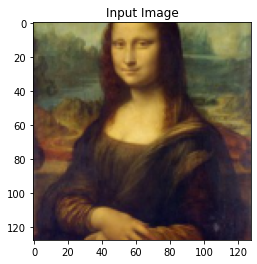

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 183.260483 Content Loss: 18.277025

run [100]:
Style Loss : 92.521751 Content Loss: 18.628508

run [150]:
Style Loss : 72.207954 Content Loss: 18.678680

run [200]:
Style Loss : 63.959801 Content Loss: 18.669666

run [250]:
Style Loss : 59.962776 Content Loss: 18.560162

run [300]:
Style Loss : 57.026176 Content Loss: 18.482529

CPU times: user 6.02 s, sys: 253 ms, total: 6.28 s
Wall time: 6.31 s


In [ ]:
%%time
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, masks, input_img, num_steps=300, style_weight=1000000)

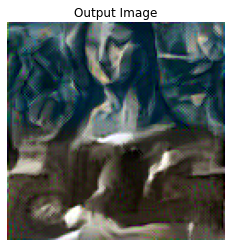

In [ ]:
plt.axis("off")
imshow(output, title='Output Image')

## <center>Примеры

## 1)

In [ ]:
style_img1 = image_loader("images/orfizm.jpg")
style_img2 = image_loader("images/lu4izm.jpg")
style_imgs = [style_img1, style_img2]

content_img = image_loader("images/cont_zhizn-semya1.jpg")

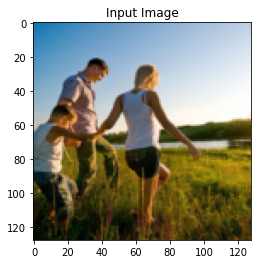

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 242.841217 Content Loss: 92.553429

run [100]:
Style Loss : 104.796654 Content Loss: 97.897476

run [150]:
Style Loss : 64.124634 Content Loss: 98.251678

run [200]:
Style Loss : 51.740376 Content Loss: 96.811050

run [250]:
Style Loss : 69.483009 Content Loss: 95.372742

run [300]:
Style Loss : 43.644638 Content Loss: 95.307755

CPU times: user 5.76 s, sys: 263 ms, total: 6.03 s
Wall time: 6.07 s


In [ ]:
%%time
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, masks, input_img, num_steps=300, style_weight=100000)

In [ ]:
# plt.axis("off")
# imshow(output, title='Output Image')

In [ ]:
def plot_styled(output, content_img, style_img1, style_img2):
    plt.figure(figsize=(24, 6))
    for i, (title, img) in enumerate(zip(["Output", "Input (content)", "Style1", "Style2"], 
                                        [output, content_img, style_img1, style_img2])):
        plt.subplot(1, 4, i+1)
        plt.axis("off")
        image = img.cpu().clone()   
        image = image.squeeze(0)      # функция для отрисовки изображения
        image = unloader(image)
        plt.imshow(image)
        plt.title(title)

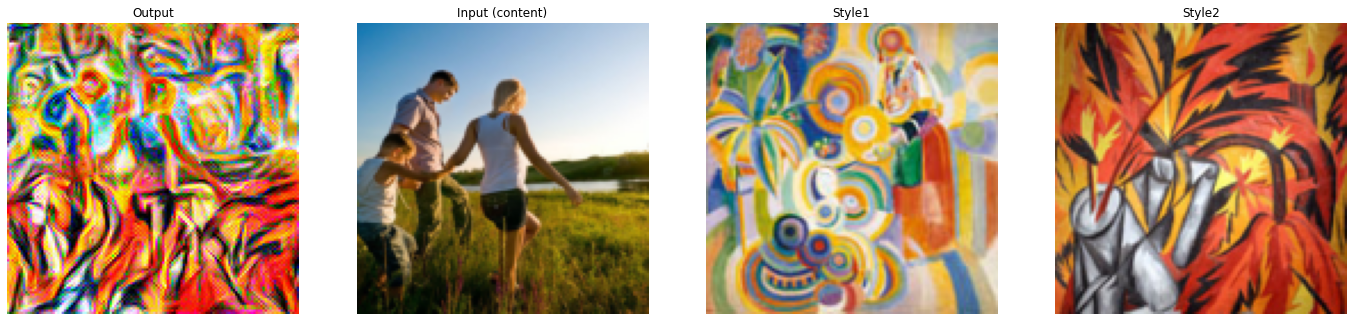

In [ ]:
plot_styled(output, content_img, style_img1, style_img2)

## 2)

In [ ]:
style_img1 = image_loader("images/andegraund.jpg")
style_img2 = image_loader("images/lu4izm.jpg")
style_imgs = [style_img1, style_img2]

content_img = image_loader("images/cont_zhizn-semya1.jpg")

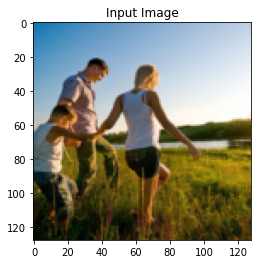

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 19.451941 Content Loss: 38.591560

run [100]:
Style Loss : 11.936562 Content Loss: 36.585350

run [150]:
Style Loss : 26.017715 Content Loss: 37.775070

run [200]:
Style Loss : 22.058222 Content Loss: 46.223137

run [250]:
Style Loss : 17.688742 Content Loss: 44.870926

run [300]:
Style Loss : 87.256897 Content Loss: 49.467876

CPU times: user 5.69 s, sys: 260 ms, total: 5.95 s
Wall time: 5.98 s


In [ ]:
%%time
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, masks, input_img, num_steps=300, style_weight=10000)

In [ ]:
# plt.axis("off")
# imshow(output, title='Output Image')

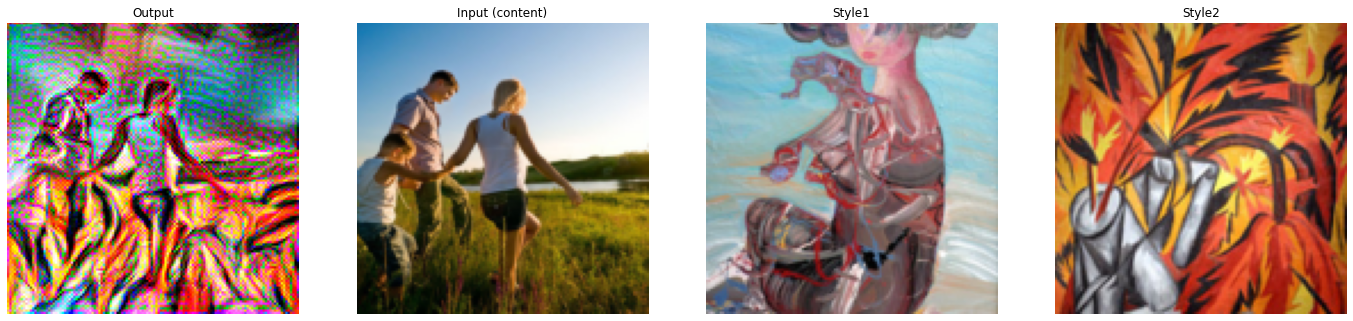

In [ ]:
plot_styled(output, content_img, style_img1, style_img2)

## 3)

In [ ]:
style_img1 = image_loader("images/andegraund.jpg")
style_img2 = image_loader("images/konstruktivizm.jpg")
style_imgs = [style_img1, style_img2]

content_img = image_loader("images/cont_zhizn-semya1.jpg")

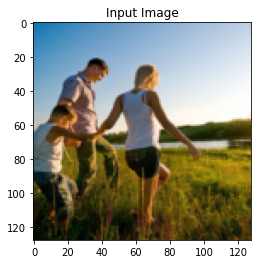

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 34.282711 Content Loss: 39.486172

run [100]:
Style Loss : 21.525230 Content Loss: 39.656296

run [150]:
Style Loss : 29187.845703 Content Loss: 247.801971

run [200]:
Style Loss : 36.708969 Content Loss: 69.598076

run [250]:
Style Loss : 22.832184 Content Loss: 59.609745

run [300]:
Style Loss : 30.359859 Content Loss: 57.932373

CPU times: user 5.76 s, sys: 236 ms, total: 6 s
Wall time: 6.03 s


In [ ]:
%%time
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, masks, input_img, num_steps=300, style_weight=10000)

In [ ]:
# plt.axis("off")
# imshow(output, title='Output Image')

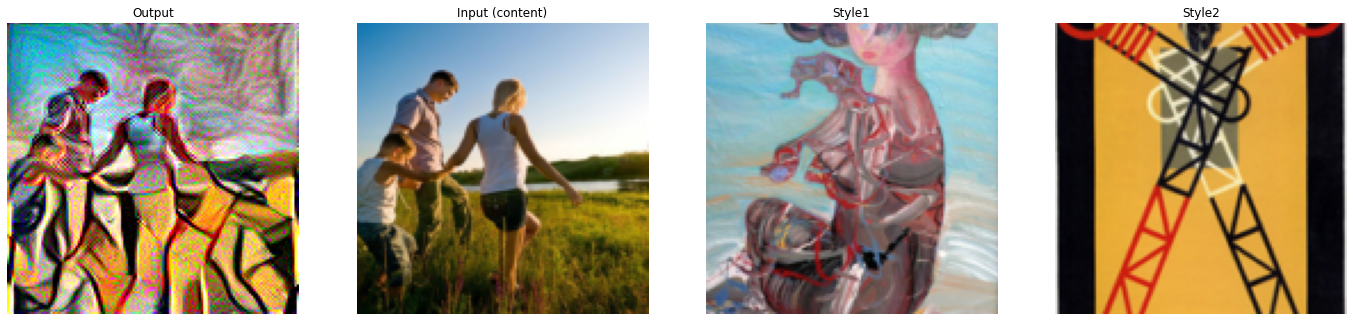

In [ ]:
plot_styled(output, content_img, style_img1, style_img2)

## 4)

In [ ]:
style_img1 = image_loader("images/neoexpressionism.jpg")
style_img2 = image_loader("images/Dekorativnay.jpg")
style_imgs = [style_img1, style_img2]

content_img = image_loader("images/cont_zhizn-semya1.jpg")

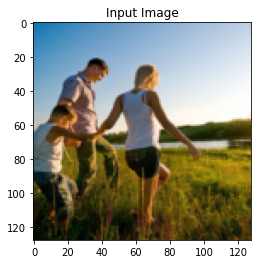

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 21.198946 Content Loss: 32.334259

run [100]:
Style Loss : 14.545949 Content Loss: 34.572620

run [150]:
Style Loss : 26.849722 Content Loss: 32.888485

run [200]:
Style Loss : 14.373331 Content Loss: 33.459972

CPU times: user 3.86 s, sys: 156 ms, total: 4.02 s
Wall time: 4.05 s


In [ ]:
%%time
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_imgs, masks, input_img, num_steps=200, style_weight=10000)

In [ ]:
# plt.axis("off")
# imshow(output, title='Output Image')

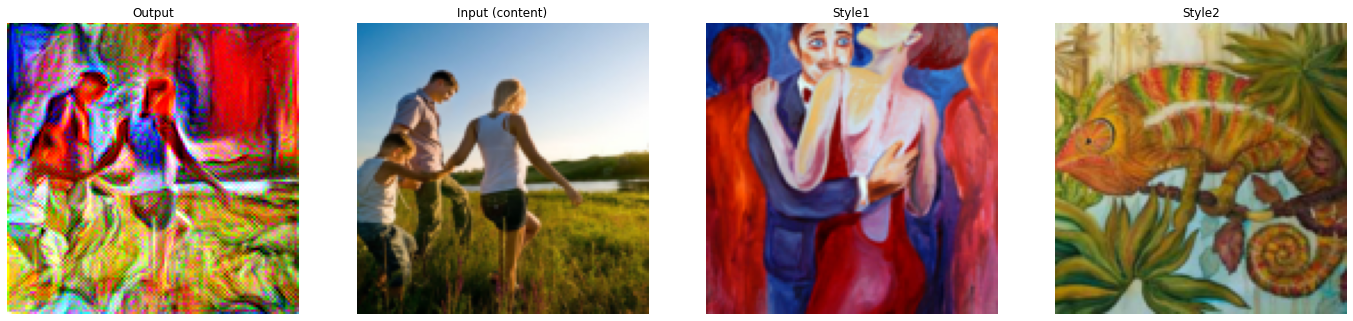

In [ ]:
plot_styled(output, content_img, style_img1, style_img2)